# Understanding Hired Rides in NYC

_[Project prompt](https://docs.google.com/document/d/1VERPjEZcC1XSs4-02aM-DbkNr_yaJVbFjLJxaYQswqA/edit#)_

_This scaffolding notebook may be used to help setup your final project. It's **totally optional** whether you make use of this or not._

_If you do use this notebook, everything provided is optional as well - you may remove or add prose and code as you wish._

_Anything in italics (prose) or comments (in code) is meant to provide you with guidance. **Remove the italic lines and provided comments** before submitting the project, if you choose to use this scaffolding. We don't need the guidance when grading._

_**All code below should be consider "pseudo-code" - not functional by itself, and only a suggestion at the approach.**_

## Requirements

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project._

* Code clarity: make sure the code conforms to:
    * [ ] [PEP 8](https://peps.python.org/pep-0008/) - You might find [this resource](https://realpython.com/python-pep8/) helpful as well as [this](https://github.com/dnanhkhoa/nb_black) or [this](https://jupyterlab-code-formatter.readthedocs.io/en/latest/) tool
    * [ ] [PEP 257](https://peps.python.org/pep-0257/)
    * [ ] Break each task down into logical functions
* The following files are submitted for the project (see the project's GDoc for more details):
    * [ ] `README.md`
    * [ ] `requirements.txt`
    * [ ] `.gitignore`
    * [ ] `schema.sql`
    * [ ] 6 query files (using the `.sql` extension), appropriately named for the purpose of the query
    * [x] Jupyter Notebook containing the project (this file!)
* [x] You can edit this cell and add a `x` inside the `[ ]` like this task to denote a completed task

## Project Setup

In [39]:
# all import statements needed for the project, for example:

import math

import bs4
import matplotlib.pyplot as plt
import pandas as pd
import requests
import sqlalchemy as db
import re
import os
from pyarrow.parquet import ParquetFile
import pyarrow as pa 
import glob




import numpy as np



import sqldf
from pandasql import sqldf

from keplergl import KeplerGl

from datetime import datetime
import geopandas as gpd
import sqlite3
from sqlalchemy.orm import sessionmaker
from pathlib import Path

In [2]:
# any general notebook setup, like log formatting

In [2]:
# any constants you might need, for example:

TAXI_URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"
# add other constants to refer to any local data, e.g. uber & weather
UBER_CSV = "uber_rides_sample.csv"

NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))

DATABASE_URL = "sqlite:///project.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries"

## Part 1: Data Preprocessing

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project. The order of these tasks aren't necessarily the order in which they need to be done. It's okay to do them in an order that makes sense to you._

* [ ] Define a function that calculates the distance between two coordinates in kilometers that **only uses the `math` module** from the standard library.
* [ ] Taxi data:
    * [ ] Use the `re` module, and the packages `requests`, BeautifulSoup (`bs4`), and (optionally) `pandas` to programmatically download the required CSV files & load into memory.
    * You may need to do this one file at a time - download, clean, sample. You can cache the sampling by saving it as a CSV file (and thereby freeing up memory on your computer) before moving onto the next file. 
* [ ] Weather & Uber data:
    * [ ] Download the data manually in the link provided in the project doc.
* [ ] All data:
    * [ ] Load the data using `pandas`
    * [ ] Clean the data, including:
        * Remove unnecessary columns
        * Remove invalid data points (take a moment to consider what's invalid)
        * Normalize column names
        * (Taxi & Uber data) Remove trips that start and/or end outside the designated [coordinate box](http://bboxfinder.com/#40.560445,-74.242330,40.908524,-73.717047)
    * [ ] (Taxi data) Sample the data so that you have roughly the same amount of data points over the given date range for both Taxi data and Uber data.
* [ ] Weather data:
    * [ ] Split into two `pandas` DataFrames: one for required hourly data, and one for the required daily daya.
    * [ ] You may find that the weather data you need later on does not exist at the frequency needed (daily vs hourly). You may calculate/generate samples from one to populate the other. Just document what you’re doing so we can follow along. 

### Calculating distance
_**TODO:** Write some prose that tells the reader what you're about to do here._

In [4]:
def calculate_distance(from_coord, to_coord):
    lon1 = math.radians(from_coord[0])
    lon2 = math.radians(to_coord[0])
    lat1 = math.radians(from_coord[1])
    lat2 = math.radians(to_coord[1])
      
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
 
    c = 2 * math.asin(math.sqrt(a))
    
    # Radius of earth in kilometers. Use 3956 for miles
    r = 6371
      
    # calculate the result
    return(c * r)
   

In [5]:
#unit test
from_coord=[-1.7297222222222221, 53.32055555555556]
to_coord=[-1.6997222222222223, 53.31861111111111]
assert calculate_distance(from_coord, to_coord)==2.0043678382716137

In [6]:
def add_distance_column(dataframe):
#     dis=[]
#     for x_1, y_1, x_2,y_2 in zip(dataframe["pickup_longitude"], dataframe["pickup_latitude"], dataframe["dropoff_longitude"], dataframe["dropoff_latitude"]):
#         from_c=[x_1, y_1]
#         to_c=[x_2, y_2]
#         d=calculate_distance(from_c, to_c)
#         dis.append(d)
#     dataframe["distance"]=dis
    dataframe["distance"]=dataframe.apply(lambda row:calculate_distance([row['pickup_longitude'],row['pickup_latitude']], [row['dropoff_longitude'],row['dropoff_latitude']]),axis=1)
    return dataframe
    

### Processing Taxi Data

_**TODO:** Write some prose that tells the reader what you're about to do here._

In [7]:
TAXI_URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"


def get_taxi_html():
    response = requests.get(TAXI_URL)
    html = response.content
    return html
def find_taxi_links():
    #find yellow taxi links from 2009-2015/06
    html = get_taxi_html()
    soup = bs4.BeautifulSoup(html, "html.parser")
#     green_a_tags = soup.find_all("a", attrs={"title": "Green Taxi Trip Records"})
    yellow_a_tags = soup.find_all("a", attrs={"title": "Yellow Taxi Trip Records"})
    all_a_tags =  yellow_a_tags
    res=[]
    for a in all_a_tags:
        yyyy, mm = re.search(r'([0-9]+)-([0-9]+).parquet$', a["href"]).groups()
        if ((int(yyyy) >= 2009) and (int(yyyy) <2015))  or ((int(yyyy) == 2015) and (int(mm) <= 6)):
            res.append(a["href"])
#             print(yyyy+mm)
           
    return res
links = find_taxi_links()
links

['https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2015-01.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2015-02.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2015-03.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2015-04.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2015-05.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2015-06.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2014-01.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2014-02.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2014-03.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2014-04.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2014-05.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2014-06.pa

In [8]:
cols=[]
def get_col_name(urls):
    for i in urls:
        df=pd.read_parquet(i)
        col=list(df.columns)
        if not col in cols:
            cols.append(col)
get_col_name(links)
cols

[['VendorID',
  'tpep_pickup_datetime',
  'tpep_dropoff_datetime',
  'passenger_count',
  'trip_distance',
  'RatecodeID',
  'store_and_fwd_flag',
  'PULocationID',
  'DOLocationID',
  'payment_type',
  'fare_amount',
  'extra',
  'mta_tax',
  'tip_amount',
  'tolls_amount',
  'improvement_surcharge',
  'total_amount',
  'congestion_surcharge',
  'airport_fee'],
 ['vendor_id',
  'pickup_datetime',
  'dropoff_datetime',
  'passenger_count',
  'trip_distance',
  'pickup_longitude',
  'pickup_latitude',
  'rate_code',
  'store_and_fwd_flag',
  'dropoff_longitude',
  'dropoff_latitude',
  'payment_type',
  'fare_amount',
  'surcharge',
  'mta_tax',
  'tip_amount',
  'tolls_amount',
  'total_amount'],
 ['vendor_name',
  'Trip_Pickup_DateTime',
  'Trip_Dropoff_DateTime',
  'Passenger_Count',
  'Trip_Distance',
  'Start_Lon',
  'Start_Lat',
  'Rate_Code',
  'store_and_forward',
  'End_Lon',
  'End_Lat',
  'Payment_Type',
  'Fare_Amt',
  'surcharge',
  'mta_tax',
  'Tip_Amt',
  'Tolls_Amt',
  

In [26]:
#Since there are three kinds of cols, we need to normalzie and clean them in different ways
cols=[['VendorID',
  'tpep_pickup_datetime',
  'tpep_dropoff_datetime',
  'passenger_count',
  'trip_distance',
  'RatecodeID',
  'store_and_fwd_flag',
  'PULocationID',
  'DOLocationID',
  'payment_type',
  'fare_amount',
  'extra',
  'mta_tax',
  'tip_amount',
  'tolls_amount',
  'improvement_surcharge',
  'total_amount',
  'congestion_surcharge',
  'airport_fee'],
 ['vendor_id',
  'pickup_datetime',
  'dropoff_datetime',
  'passenger_count',
  'trip_distance',
  'pickup_longitude',
  'pickup_latitude',
  'rate_code',
  'store_and_fwd_flag',
  'dropoff_longitude',
  'dropoff_latitude',
  'payment_type',
  'fare_amount',
  'surcharge',
  'mta_tax',
  'tip_amount',
  'tolls_amount',
  'total_amount'],
 ['vendor_name',
  'Trip_Pickup_DateTime',
  'Trip_Dropoff_DateTime',
  'Passenger_Count',
  'Trip_Distance',
  'Start_Lon',
  'Start_Lat',
  'Rate_Code',
  'store_and_forward',
  'End_Lon',
  'End_Lat',
  'Payment_Type',
  'Fare_Amt',
  'surcharge',
  'mta_tax',
  'Tip_Amt',
  'Tolls_Amt',
  'Total_Amt']]

In [27]:
shapefile_url='https://d37ci6vzurychx.cloudfront.net/misc/taxi_zones.zip'
def read_shapefile(url):
    df_loc = gpd.read_file(url)
    df_loc["geometry"]=df_loc["geometry"].to_crs(4326)
    df_loc['lon']=df_loc.centroid.x  
    df_loc['lat']=df_loc.centroid.y
    return df_loc
df_loc=read_shapefile(shapefile_url)
df_loc

/var/folders/nw/1r3hpqbs7kzctwcvcp2lckr00000gn/T/ipykernel_35450/2635983630.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_loc['lon']=df_loc.centroid.x
/var/folders/nw/1r3hpqbs7kzctwcvcp2lckr00000gn/T/ipykernel_35450/2635983630.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_loc['lat']=df_loc.centroid.y


,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,lon,lat
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((-74.18445 40.69500, -74.18449 40.695...",-74.174000,40.691831
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ...",-73.831299,40.616745
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((-73.84793 40.87134, -73.84725 40.870...",-73.847422,40.864474
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((-73.97177 40.72582, -73.97179 40.725...",-73.976968,40.723752
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((-74.17422 40.56257, -74.17349 40.562...",-74.188484,40.552659
...,...,...,...,...,...,...,...,...,...
258,259,0.126750,0.000395,Woodlawn/Wakefield,259,Bronx,"POLYGON ((-73.85107 40.91037, -73.85207 40.909...",-73.852215,40.897932
259,260,0.133514,0.000422,Woodside,260,Queens,"POLYGON ((-73.90175 40.76078, -73.90147 40.759...",-73.906306,40.744235
260,261,0.027120,0.000034,World Trade Center,261,Manhattan,"POLYGON ((-74.01333 40.70503, -74.01327 40.704...",-74.013023,40.709139
261,262,0.049064,0.000122,Yorkville East,262,Manhattan,"MULTIPOLYGON (((-73.94383 40.78286, -73.94376 ...",-73.946510,40.775932


In [28]:
#map to pick up ID and drop off ID to the latitude and longitude
dic_lon=df_loc['lon'].to_dict()
dic_lat=df_loc['lat'].to_dict()
def map_loc_id(dataframe):
    dataframe=dataframe[dataframe.PULocationID<=262]
    dataframe=dataframe[dataframe.DOLocationID<=262]
    dataframe['pickup_longitude']=dataframe['PULocationID'].map(dic_lon)
    dataframe['pickup_latitude']=dataframe['PULocationID'].map(dic_lat)
    dataframe['dropoff_longitude']=dataframe['DOLocationID'].map(dic_lon)
    dataframe['dropoff_latitude']=dataframe['DOLocationID'].map(dic_lat)
    return dataframe

In [33]:
def clean_taxi_data(df):
    #remove location out of range
    df = df[(df["pickup_longitude"] > -74.242330) 
   & (df["pickup_longitude"] < -73.717047) 
   & (df["pickup_latitude"] > 40.560445) 
   & (df["pickup_latitude"] < 40.908524)]
     #remove the data that passenger count is 0
    df=df[df.passenger_count>0]
    #remove no distance data
    df=df[df.distance>0]
    #remove no fare data
    df=df[df.fare_amount>0]
    return df
   
    

In [34]:
n_cols=['pickup_datetime', 'dropoff_datetime','passenger_count', "pickup_longitude","pickup_latitude",'dropoff_longitude', 'dropoff_latitude',  'fare_amount', 'tip_amount', 'total_amount']
def get_and_clean_month_taxi_data(url):
    df=pd.read_parquet(url)
    col=list(df.columns)
    if col== cols[0]:#need to map location id
        df=map_loc_id(df)
        df=df[["tpep_pickup_datetime", "tpep_dropoff_datetime","passenger_count","pickup_longitude","pickup_latitude","dropoff_longitude","dropoff_latitude","fare_amount","tip_amount","total_amount"]]
    elif col==cols[1]:
        df=df[['pickup_datetime','dropoff_datetime','passenger_count','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','fare_amount','tip_amount','total_amount']]
    else:
        df=df[['Trip_Pickup_DateTime','Trip_Dropoff_DateTime','Passenger_Count','Start_Lon','Start_Lat','End_Lon','End_Lat','Fare_Amt','Tip_Amt','Total_Amt']]
    df.columns=n_cols
    df=add_distance_column(df)
    df=clean_taxi_data(df)
    df=df.sample(n=2500)
    return df
    

In [35]:
def get_and_clean_taxi_data():
    all_taxi_dataframes = []
    for csv_url in links:
        # maybe: first try to see if you've downloaded this exact
        # file already and saved it before trying again
        dataframe = get_and_clean_month_taxi_data(csv_url)
        # maybe: if the file hasn't been saved, save it so you can
        # avoid re-downloading it if you re-run the function
        all_taxi_dataframes.append(dataframe)
    # create one gigantic dataframe with data from every month needed
    taxi_data = pd.contact(all_taxi_dataframes)
    taxi_data['pickup_datetime']=pd.to_datetime(taxi_data['pickup_datetime'])
    taxi_data['year']=taxi_data['pickup_datetime'].dt.year
    taxi_data['month']=taxi_data['pickup_datetime'].dt.month
    taxi_data['day']=taxi_data['pickup_datetime'].dt.day
    taxi_data['dayofweek']=taxi_data['pickup_datetime'].dt.dayofweek
    return taxi_data

In [ ]:
taxi_data=get_and_clean_taxi_data()
taxi_data.to_csv('cleaned_taxi_data.csv')

### Processing Uber Data

_**TODO:** Write some prose that tells the reader what you're about to do here._

In [60]:
uber_col=['pickup_datetime', 'passenger_count', "pickup_longitude","pickup_latitude",'dropoff_longitude', 'dropoff_latitude',  'fare_amount', 'distance']
def load_and_clean_uber_data(csv_file):
    df_u = pd.read_csv(csv_file)
    df_u=df_u[['pickup_datetime','passenger_count','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','fare_amount']]
    df_u = df_u[(df_u["pickup_longitude"] > -74.242330) 
   & (df_u["pickup_longitude"] < -73.717047) 
   & (df_u["pickup_latitude"] > 40.560445) 
   & (df_u["pickup_latitude"] < 40.908524)]
   
    df_u=df_u[df_u.passenger_count>0]
    #remove no fare data
    df_u=df_u[df_u.fare_amount>0]
    df_u=df_u=add_distance_column(df_u)
    #remove no distance data
    df_u=df_u[df_u.distance>0]
    df_u.columns=uber_col
    df_u['pickup_datetime']=pd.to_datetime(df_u['pickup_datetime'])
    df_u['year']=df_u['pickup_datetime'].dt.year
    df_u['month']=df_u['pickup_datetime'].dt.month
    df_u['day']=df_u['pickup_datetime'].dt.day
    df_u['hour']=df_u['pickup_datetime'].dt.hour
    return df_u



In [61]:
UBER_DATA="4501-project/uber_rides_sample.csv"
def get_uber_data():
    uber_dataframe = load_and_clean_uber_data(UBER_DATA)
    return uber_dataframe

In [62]:
uber_dataframe=get_uber_data()
uber_dataframe

,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,distance,year,month,day,hour
0,2015-05-07 19:52:06+00:00,1,-73.999817,40.738354,-73.999512,40.723217,7.5,1.683323,2015,5,7,19
1,2009-07-17 20:04:56+00:00,1,-73.994355,40.728225,-73.994710,40.750325,7.7,2.457590,2009,7,17,20
2,2009-08-24 21:45:00+00:00,1,-74.005043,40.740770,-73.962565,40.772647,12.9,5.036377,2009,8,24,21
3,2009-06-26 08:22:21+00:00,3,-73.976124,40.790844,-73.965316,40.803349,5.3,1.661683,2009,6,26,8
4,2014-08-28 17:47:00+00:00,5,-73.925023,40.744085,-73.973082,40.761247,16.0,4.475450,2014,8,28,17
...,...,...,...,...,...,...,...,...,...,...,...,...
199995,2012-10-28 10:49:00+00:00,1,-73.987042,40.739367,-73.986525,40.740297,3.0,0.112210,2012,10,28,10
199996,2014-03-14 01:09:00+00:00,1,-73.984722,40.736837,-74.006672,40.739620,7.5,1.875050,2014,3,14,1
199997,2009-06-29 00:42:00+00:00,2,-73.986017,40.756487,-73.858957,40.692588,30.9,12.850319,2009,6,29,0
199998,2015-05-20 14:56:25+00:00,1,-73.997124,40.725452,-73.983215,40.695415,14.5,3.539715,2015,5,20,14


In [63]:
uber_dataframe.to_csv("4501-project/cleaned_uber_data",index=False)

### Processing Weather Data

_**TODO:** Write some prose that tells the reader what you're about to do here._

In [82]:
hourly=[]
def clean_month_weather_data_hourly(csv_file):
    hourly_df=pd.read_csv(file,low_memory=False)
    hourly_df["DATE"] = pd.to_datetime(hourly_df['DATE'])
    hourly_df["date"] = pd.to_datetime(hourly_df['DATE']).dt.date
    hourly_df["year"] = hourly_df["DATE"].dt.year
    hourly_df["month"] = hourly_df["DATE"].dt.month
    hourly_df["day"] = hourly_df["DATE"].dt.day
    hourly_df["hour"] = hourly_df["DATE"].dt.hour
    hourly_df['HourlyPrecipitation'] = hourly_df['HourlyPrecipitation'].fillna(0)
    hourly_df=hourly_df[['date','year','month','day','hour','HourlyWindSpeed',"HourlyPrecipitation",'DailySustainedWindSpeed']]
    hourly_df = hourly_df.replace(['T'], 0)
    hourly.append(hourly_df)
filepath = glob.glob("weather/*.csv")
for file in sorted(filepath):
    clean_month_weather_data_hourly(file)
hourly_data=pd.concat(hourly)
hourly_data = hourly_data.replace(['T'], 0)
hourly_data.fillna(0, inplace=True)
hourly_data["HourlyPrecipitation"]
hourly_data = hourly_data[(hourly_data["year"] <= 2015) &(hourly_data["month"] <=6)]
hourly_data["HourlyPrecipitation"] = pd.to_numeric(hourly_data["HourlyPrecipitation"],errors='coerce')
hourly_data.fillna(0, inplace=True)
    

In [83]:
daily= pd.DataFrame()
daily['DailySustainedWindSpeed']=hourly_data.groupby("date")["DailySustainedWindSpeed"].sum()
daily['daily_wind_speed']=hourly_data.groupby("date")["HourlyWindSpeed"].mean()
daily['daily_precipitation']=hourly_data.groupby("date")["HourlyPrecipitation"].sum()
daily.to_csv('cleaned_daily_data.csv')
daily=pd.read_csv('cleaned_daily_data.csv')
daily['date']=pd.to_datetime(daily['date'])
daily['year']=daily['date'].dt.year
daily['month']=daily['date'].dt.month
daily['day']=daily['date'].dt.day
daily=daily[['date', 'year', 'month','day','daily_wind_speed','daily_precipitation','DailySustainedWindSpeed']]
daily.to_csv('cleaned_daily_data.csv')

### Process All Data

_This is where you can actually execute all the required functions._

_**TODO:** Write some prose that tells the reader what you're about to do here._

In [20]:
#read from stored cleaned data
taxi_data = pd.read_csv('cleaned_taxi_data 3.csv')
uber_dataframe = pd.read_csv('cleaned_uber_data')
hourly_weather=pd.read_csv('cleaned_hourly_data1.csv')
daily_weather = pd.read_csv('cleaned_daily_data1.csv')

## Part 2: Storing Cleaned Data

_Write some prose that tells the reader what you're about to do here._

In [21]:
engine = db.create_engine(DATABASE_URL)

In [22]:
# if using SQL (as opposed to SQLAlchemy), define the commands 
# to create your 4 tables/dataframes
HOURLY_WEATHER_SCHEMA = """
CREATE TABLE hourly_DATA (
 id INTEGER PRIMARY KEY,
 'Unamed: 0' INTEGER,
 'date' TEXT
 'year' INTEGER
 'month' INTEGER
 'day' INTEGER
 'HourlyWindSpeed' REAL
 'HourlyPrecipitation' REAL
 'DailySustainedWindSpeed' REAL);"""

DAILY_WEATHER_SCHEMA = """
CREATE TABLE daily_DATA (
 id INTEGER PRIMARY KEY,
 'Unamed: 0' INTEGER,
 'date' TEXT
 'year' INTEGER
 'month' INTEGER
 'day' INTEGER
 'hour' INTEGER
 'daily_wind_speed' REAL
 'daily_precipitation' REAL
 'DailySustainedWindSpeed' REAL
);"""


TAXI_TRIPS_SCHEMA = """
CREATE TABLE taxi_data (
  id INTEGER PRIMARY KEY,
  'Unamed: 0' INTEGER,
  'pickup_datetime' TEXT,
  'dropoff_datetime' TEXT,
  'passenger_count' INTEGER,
  'pickup_longitude' REAL,
  'pickup_latitude' REAL,
  'dropoff_longitude' REAL,
  'dropoff_latitude' REAL,
  'fare_amount' REAL,
  'tip_amount' REAL,
  'total_amount' REAL,
  'distance' REAL,
  'year' INTEGER,
  'month' INTEGER,
  'day' INTEGER,
  'hour' INTEGER
);
"""

UBER_TRIPS_SCHEMA = """CREATE TABLE uber_data (
  id INTEGER PRIMARY KEY,
  'pickup_datetime' TIMESTAMP,
  'passenger_count' INTEGER,
  'pickup_longitude' REAL,
  'pickup_latitud' REAL,
  'dropoff_longitude' REAL,
  'dropoff_latitude' REAL,
  'fare_amount' REAL,
  'distance' REAL,
  'year' INTEGER,
  'month' INTEGER,
  'day' INTEGER,
  'hour' INTEGER,
  'dayofweek' INTEGER
);

"""

In [8]:
# create that required schema.sql file
with open("schema.sql", "w") as f:
    f.write(HOURLY_WEATHER_SCHEMA)
    f.write(DAILY_WEATHER_SCHEMA)
    f.write(TAXI_TRIPS_SCHEMA)
    f.write(UBER_TRIPS_SCHEMA)
    

In [23]:
# create the tables with the schema files
with engine.connect() as connection:
    pass

### Add Data to Database

We add data from csv and parquet files into SQLlite database

In [24]:
Path('daily_f.db').touch()
Path('hourly_f.db').touch()
Path('uber_f.db').touch()
Path('taxi_f.db').touch()

In [25]:
table_uber = sqlite3.connect('uber_f.db')
c = table_uber.cursor()
c.execute(UBER_TRIPS_SCHEMA)
uber_dataframe.to_sql('uber_f', table_uber, if_exists='append', index = False)

193159

In [26]:
table_taxi = sqlite3.connect('taxi_f.db')
c1 = table_taxi.cursor()
c1.execute(TAXI_TRIPS_SCHEMA)
taxi_data.to_sql('taxi_f', table_taxi, if_exists='append', index = False) 

195000

In [28]:
table_hourly = sqlite3.connect('hourly_f.db')
c3 = table_hourly.cursor()
c3.execute(HOURLY_WEATHER_SCHEMA)
hourly_weather.to_sql('hourly_f', table_hourly, if_exists='append', index = False) 

72411

In [29]:
table_daily = sqlite3.connect('daily_f.db')
c2 = table_daily.cursor()
c2.execute(DAILY_WEATHER_SCHEMA)
daily_weather.to_sql('daily_f', table_daily, if_exists='append', index = False) 

2367

In [30]:
map_table_name_to_dataframe = {
    "daily_weather" : table_daily,
    "hourly_weather" : table_hourly,
    "taxi_trips" : table_taxi,
    "uber_trips": table_uber
}

## Part 3: Understanding the Data

In [31]:
#Define a function for storing query
def write_query_to_file(query, outfile):
    with open(outfile, "w") as f:
        f.write(query)

### Query N

_**TODO:** Write some prose that tells the reader what you're about to do here._

_Repeat for each query_

In [16]:
#Query for question 1
QUERY_1 = """
SELECT hour, COUNT(*) as counts
FROM taxi_data
GROUP BY hour
"""
QUERY_1_1 = sqldf(QUERY_1)
QUERY_1_1

,hour,counts
0,0,7801
1,1,5749
2,2,4329
3,3,3211
4,4,2336
5,5,1905
6,6,3953
7,7,7079
8,8,8853
9,9,9191


In [17]:
# storing the query
outfile1 = "Most_pop_h_yellowtaxi.sql"
write_query_to_file(QUERY_1, outfile1)

### Query 2: For the same time frame, what day of the week was the most popular to take an uber? The result should have 7 bins.
This query is reponsible for answer the question: For the same time frame, what day of the week was the most popular to take an uber? The result should have 7 bins. We need to select day of week from the uber dataframe. Then count the passanger number for each day. Similarly, we order it by descending order and only choose the first row in table. Lastly, storing the query in a sql file called "Most_pop_dayofweek_uber.sql"

The answer for the second question is the most pouplar day is 2(Tuesday) and the number of rides is 6669.

In [18]:
#Query for question 2
QUERY_2 = """
SELECT dayofweek+1 AS day, 
COUNT(*) AS counts 
FROM uber_dataframe
GROUP BY dayofweek;
"""
Result_2 = sqldf(QUERY_2)
Result_2

,day,counts
0,1,24331
1,2,27197
2,3,28022
3,4,29008
4,5,29800
5,6,29257
6,7,25544


In [19]:
outfile2 = "Most_pop_dayofweek_uber.sql"
write_query_to_file(QUERY_2, outfile2)

### Query 3: What is the 95% percentile of distance traveled for all hired trips during July 2013?
This query is reponsible for answer the question: What is the 95% percentile of distance traveled for all hired trips during July 2013? Then set up the time frame. Similarly, we order it by descending order and only choose the first row in table. Lastly, storing the query in a sql file called "95%_percentile_distance.sql"

The answer for the third question is 28.63277.

In [20]:
#Query for question 3
#Query for question 3
QUERY_3 = """
SELECT PERCENT_RANK() OVER(ORDER BY distance) AS Percent_95, distance
FROM taxi_data

UNION 
SELECT PERCENT_RANK() OVER(ORDER BY distance) AS Percent_95, distance
FROM uber_dataframe

"""
Result_3 = sqldf(QUERY_3)
Result_3

QUERY_3_2="""
SELECT distance
FROM Result_3
WHERE Percent_95 >= 0.95
LIMIT 1
"""
QUERY_3_3 = sqldf(QUERY_3_2)
QUERY_3_3 

,distance
0,10.120772


In [21]:
# storing the query
with open("schema.sql", "w") as f:
    f.write(QUERY_3)
    f.write(QUERY_3_2)
    


### Query 4: What were the top 10 days with the highest number of hired rides for 2009, and what was the average distance for each day?
This query is reponsible for answer the question: What were the top 10 days with the highest number of hired rides for 2009, and what was the average distance for each day? We need to calculate avgerage distance, select days, month, and number of rides from the taxi dataframe. Then order the table by descending order and extract the top 10 rows.  Lastly, storing the query in a sql file called "Top_10_days_highest_number_avg.sql"

The answer for the fourth question is in the following table.

In [22]:
#Query for question 4
QUERY_4 = """
SELECT month, day, COUNT(*) AS num_rides, AVG(distance) as avg_dist
FROM uber_dataframe
WHERE year = 2009
GROUP BY month, day
UNION
SELECT month, day, COUNT(*) AS num_rides, AVG(distance) as avg_dist
FROM taxi_data
WHERE year = 2009
GROUP BY month, day
ORDER BY num_rides DESC
LIMIT 10;
"""
Result_4 = sqldf(QUERY_4)
Result_4

,month,day,num_rides,avg_dist
0,12,11,127,2.975892
1,10,23,121,2.493004
2,8,14,118,3.578691
3,12,4,116,2.782468
4,2,28,113,3.154252
5,4,18,113,3.329794
6,4,23,110,2.960566
7,11,20,110,2.800906
8,1,31,109,2.868794
9,2,27,108,2.908646


In [23]:
# storing the query
outfile4 = "Top_10_days_highest_number_avg.sql"
write_query_to_file(QUERY_4, outfile4)

### Query 5: Which 10 days in 2014 were the windiest, and how many hired trips were made on those days?
In this question, we find the top 10 days which were the windiest and the hired trips on those days. The data are shown in the following table. 

In [24]:
QUERY_5 = """
SELECT COUNT(*) AS counts,d.year, d.month, d.day, d.daily_wind_speed AS windspeed
FROM daily_weather d
JOIN taxi_data t ON t.day = d.day AND t.month = d.month
JOIN uber_dataframe u ON u.day = d.day AND u.month = d.month
WHERE d.year = 2014
GROUP BY d.day, d.month
ORDER BY windspeed DESC
LIMIT 10
"""

top_10_wind = sqldf(QUERY_5)
top_10_wind

,counts,year,month,day,windspeed
0,388642,2014,3,13,12.923077
1,302059,2014,1,7,12.560000
2,169330,2014,1,2,12.352941
3,358775,2014,2,13,11.781818
4,341598,2014,3,29,11.666667
5,305409,2014,12,7,11.153846
6,265081,2014,12,9,11.056604
7,297550,2014,12,8,10.903226
8,361496,2014,3,26,10.520000
9,222300,2014,1,3,9.710526


In [25]:
# storing the query
outfile5 = "Top_10_days_windday_num_trips.sql"
write_query_to_file(QUERY_5, outfile5)

### QUERY 6: During Hurricane Sandy in NYC (Oct 29-30, 2012) and the week leading up to it, how many trips were taken each hour, and for each hour, how much precipitation did NYC receive and what was the sustained wind speed?
The answers are in tables and query has been stored into our_preci_and_wind.sql.

In [26]:
QUERY_6 = """
SELECT h.hour, h.year, h.month, h.day,
       AVG(HourlyPrecipitation) AS avg_precipitation,
       DailySustainedWindSpeed AS sustained_windspeed,
       COUNT(*) AS trips
FROM hourly_weather h
JOIN taxi_data t ON t.month = h.month AND t.day = h.day AND t.year = h.year
JOIN uber_dataframe u ON u.month = h.month AND u.day = h.day AND u.year = h.year
WHERE h.year = 2012 AND h.month = 10 AND h.day BETWEEN 29 AND 30
GROUP BY h.month, h.day, h.hour
"""
hour_preci_and_wind = sqldf(QUERY_6)
hour_preci_and_wind 

,hour,year,month,day,avg_precipitation,sustained_windspeed,trips
0,0,2012,10,29,0.0000,0.0,588
1,1,2012,10,29,0.0000,0.0,588
2,2,2012,10,29,0.0000,0.0,588
3,3,2012,10,29,0.0000,0.0,588
4,4,2012,10,29,0.0000,0.0,588
5,5,2012,10,29,0.0000,0.0,588
6,6,2012,10,29,0.0200,0.0,588
7,7,2012,10,29,0.0200,0.0,588
8,8,2012,10,29,0.0000,0.0,588
9,9,2012,10,29,0.0000,0.0,588


In [27]:
outfile6 = "Hour_preci_and_wind.sql"
write_query_to_file(QUERY_6, outfile6)

## Part 4: Visualizing the Data


### Visualization 1: Create an appropriate visualization for the first query in part 3.
We use matplotlib library to plot a line chart for this question. 

In [28]:
# get dataset which is used to plot for question 1
def data_for_visual_q1():
    dataframe = QUERY_1_1
    return dataframe

In [29]:
#define function for question 1
def plot_question1(dataframe):
    plt.title("Plot1: Hour of the day was the most popular to take a yellow taxi")
    x = dataframe['hour']
    y = dataframe['counts']
    plt.bar(x,y)

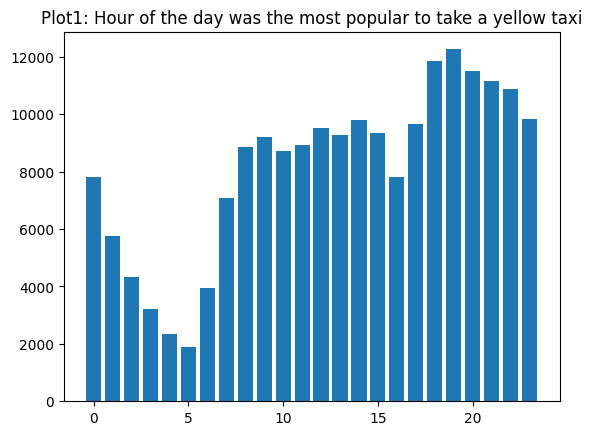

In [30]:
# plot a line chart
num_rides_hour_a_day = data_for_visual_q1()
plot_question1(num_rides_hour_a_day)

### Visualization 2: Create a visualization that shows the average distance traveled per month (regardless of year - so group by each month) for both taxis and Ubers combined. Include the 90% confidence interval around the mean in the visualization.
We use matplotlib library to plot a line chart for this question and add CI on the graph.

In [41]:
# get dataset which is used to plot for question 2
def data_for_visual_q2():
    #read data from uber and taxi SQLlite database
    dist_list_taxi=c1.execute('SELECT month, distance, AVG(distance) FROM taxi_f GROUP BY month').fetchall()
    dist_list_uber=c.execute('SELECT month, distance, AVG(distance) FROM uber_f GROUP BY month').fetchall()
    #Put them into pandas dataframe
    df_taxi = pd.DataFrame (dist_list_taxi, columns = ['month','distance', 'avg_dist'])
    df_uber = pd.DataFrame (dist_list_uber, columns = ['month','distance', 'avg_dist'])
    #combine them together
    uber_taxi_dista = pd.concat([df_taxi, df_uber], axis=0)
    #CI 
    data_uber_taxi = """
    SELECT month, 
    AVG(distance) as avg_dist, 
    COUNT(*) as count,
    SQRT(AVG(distance*distance) - AVG(distance)*AVG(distance)) AS std
    FROM uber_taxi_dista
    GROUP BY month
    """
    vis_table_uber_taxi= sqldf(data_uber_taxi)
    return vis_table_uber_taxi

In [42]:
#define function for question 2
def plot_question2(dataframe):
    plt.title("Plot2: Average distance traveled per month and 90% Confidence Interval")
    plt.xlabel("Month")
    plt.ylabel("Average Distance")
    x=dataframe['month']
    y = dataframe['avg_dist']
    plt.plot(x, y)
    dev = 1.645 * dataframe["std"]/np.sqrt(dataframe["count"])
    plt.fill_between(x, (y-dev), (y+dev))

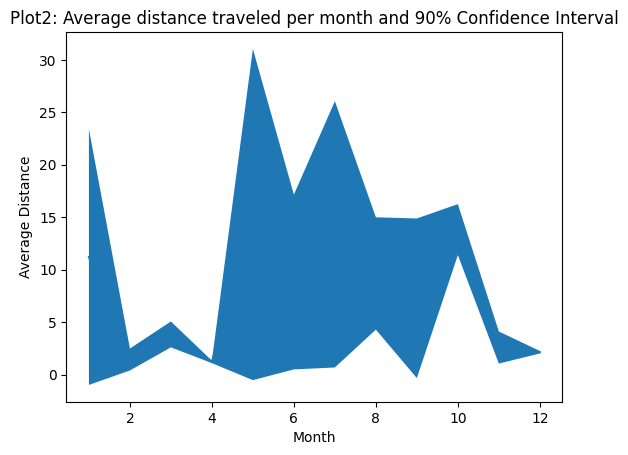

In [43]:
# plot a line chart for question 2 as well as the CI 
vis_table_uber_taxi = data_for_visual_q2()
plot_question2(vis_table_uber_taxi)

In [46]:
#store sql query
dist_list_taxi=c1.execute('SELECT month, distance, AVG(distance) FROM taxi_f GROUP BY month').fetchall()
dist_list_uber=c.execute('SELECT month, distance, AVG(distance) FROM uber_f GROUP BY month').fetchall()
df_taxi = pd.DataFrame (dist_list_taxi, columns = ['month','distance', 'avg_dist'])
df_uber = pd.DataFrame (dist_list_uber, columns = ['month','distance', 'avg_dist'])
uber_taxi_dista = pd.concat([df_taxi, df_uber], axis=0)
data_uber_taxi = """
    SELECT month, 
    AVG(distance) as avg_dist, 
    COUNT(*) as count,
    SQRT(AVG(distance*distance) - AVG(distance)*AVG(distance)) AS std
    FROM uber_taxi_dista
    GROUP BY month
    """
vis_table_uber_taxi= sqldf(data_uber_taxi)
outfile7 = "visual_uber_taxi.sql"
write_query_to_file(data_uber_taxi, outfile7)

Visualization 3: Define three lat/long coordinate boxes around the three major New York airports: LGA, JFK, and EWR (you can use bboxfinder to help). Create a visualization that compares what day of the week was most popular for drop offs for each airport.
In this question, we first defined the lat/long coordinate for LGA, JFK, and EWR. Then we read data from SQLlite database we constructed before. After that, we converted the list to pandas dataframe and combined uber's data and taxi's data together. Recall that we have defined lat/long coordinate for LGA, JFK, and EWR. We used them as ranges and only select rows which drop off lats/logs are beside these ranges. Then, we wrote queries for different airports to find the num of rides in each day. The queries gave us three tables and we combined them for visulaizing.

In [47]:
# define lat/long coordinate for LGA, JFK, and EWR.
LGA = [40.770105, -73.887206, 40.767718, -73.864755]
JFK = [40.659315, -73.810115, 40.649878, -73.756619]
EWR = [40.669658, -74.177492, 40.704877, -74.151806]

In [48]:
def data_for_visual_q3():
    #get drop off data and passanger number data from SQLlite table
    pop_list_taxi=c1.execute('SELECT dropoff_longitude, dropoff_latitude, dayofweek, passenger_count FROM taxi_f').fetchall()
    pop_list_uber=c.execute('SELECT dropoff_longitude, dropoff_latitude, dayofweek, passenger_count FROM uber_f').fetchall()
    pop_taxi_df = pd.DataFrame (pop_list_taxi, columns = ['dropoff_longitude','dropoff_latitude', 'dayofweek', 'passenger_count'])
    pop_uber_df = pd.DataFrame (pop_list_uber, columns = ['dropoff_longitude','dropoff_latitude', 'dayofweek', 'passenger_count'])
    #combine them together
    total_pop_data = pd.concat([pop_taxi_df, pop_uber_df], axis=0)
    #sort dataset as required for both uber and yellow taxi 
    LGA_total = total_pop_data[(40.767718<total_pop_data['dropoff_latitude']) 
                               & (total_pop_data['dropoff_latitude']<40.770105) & 
              (-73.887206<total_pop_data['dropoff_longitude']) & (total_pop_data['dropoff_longitude'] < -73.864755)]
    JFK_total = total_pop_data[(40.649878<total_pop_data['dropoff_latitude']) & 
                               (total_pop_data['dropoff_latitude']<40.659315) & 
              (-73.810115<total_pop_data['dropoff_longitude']) & (total_pop_data['dropoff_longitude'] < -73.756619)]
    EWR_total = total_pop_data[(40.669658<total_pop_data['dropoff_latitude']) & 
                               (total_pop_data['dropoff_latitude']<40.704877) & 
              (-74.177492<total_pop_data['dropoff_longitude']) & (total_pop_data['dropoff_longitude'] < -74.151806)]
    EWR_query = """
    SELECT dayofweek +1 as day_of_week, COUNT(*) AS num_EWR
    FROM EWR_total
    GROUP BY dayofweek +1
    """
    EWR_vis = sqldf(EWR_query)

    LGA_query = """
    SELECT dayofweek +1 as day_of_week, COUNT(*) AS num_LGA
    FROM LGA_total
    GROUP BY dayofweek +1
    """
    LGA_vis = sqldf(LGA_query)
    JFK_query = """
    SELECT dayofweek +1 as day_of_week, COUNT(*) AS num_JFK
    FROM JFK_total
    GROUP BY dayofweek +1
    """
    JFK_vis = sqldf(JFK_query)
    total_vis = JFK_vis.merge(LGA_vis, on='day_of_week').merge(EWR_vis, on='day_of_week')
    return total_vis

In [49]:
def plot_question3(dataframe):
    plt.title("Plot3: Number of dropoffs in a day of week for each airports")
    plt.xlabel("Day of Week")
    plt.ylabel("Number of Dropoffs")
    plt.plot(dataframe['day_of_week'], dataframe['num_JFK'], label ='JFK')
    plt.plot(dataframe['day_of_week'], dataframe['num_EWR'], label ='EWR')
    plt.plot(dataframe['day_of_week'], dataframe['num_LGA'], label ='LGA')
    plt.legend()

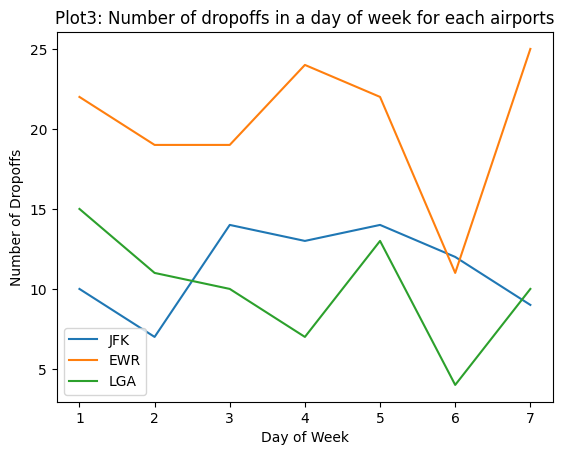

In [50]:
total_vis = data_for_visual_q3()
plot_question3(total_vis)

In [52]:
#used to store query
pop_list_taxi=c1.execute('SELECT dropoff_longitude, dropoff_latitude, dayofweek, passenger_count FROM taxi_f').fetchall()
pop_list_uber=c.execute('SELECT dropoff_longitude, dropoff_latitude, dayofweek, passenger_count FROM uber_f').fetchall()
pop_taxi_df = pd.DataFrame (pop_list_taxi, columns = ['dropoff_longitude','dropoff_latitude', 'dayofweek', 'passenger_count'])
pop_uber_df = pd.DataFrame (pop_list_uber, columns = ['dropoff_longitude','dropoff_latitude', 'dayofweek', 'passenger_count'])
total_pop_data = pd.concat([pop_taxi_df, pop_uber_df], axis=0)
LGA_total = total_pop_data[(40.767718<total_pop_data['dropoff_latitude']) 
                               & (total_pop_data['dropoff_latitude']<40.770105) & 
              (-73.887206<total_pop_data['dropoff_longitude']) & (total_pop_data['dropoff_longitude'] < -73.864755)]
JFK_total = total_pop_data[(40.649878<total_pop_data['dropoff_latitude']) & 
                               (total_pop_data['dropoff_latitude']<40.659315) & 
          (-73.810115<total_pop_data['dropoff_longitude']) & (total_pop_data['dropoff_longitude'] < -73.756619)]
EWR_total = total_pop_data[(40.669658<total_pop_data['dropoff_latitude']) & 
                               (total_pop_data['dropoff_latitude']<40.704877) & 
              (-74.177492<total_pop_data['dropoff_longitude']) & (total_pop_data['dropoff_longitude'] < -74.151806)]
EWR_query = """
    SELECT dayofweek +1 as day_of_week, COUNT(*) AS num_EWR
    FROM EWR_total
    GROUP BY dayofweek +1
    """

LGA_query = """
    SELECT dayofweek +1 as day_of_week, COUNT(*) AS num_LGA
    FROM LGA_total
    GROUP BY dayofweek +1
    """
JFK_query = """
    SELECT dayofweek +1 as day_of_week, COUNT(*) AS num_JFK
    FROM JFK_total
    GROUP BY dayofweek +1
    """
with open("Num_dropoffs_dayofweek_3airports.sql", "w") as f:
    f.write(EWR_query)
    f.write(LGA_query)
    f.write(JFK_query)

###  Visualization 4: Create a heatmap of all hired trips over a map of the area. Consider using KeplerGL or another library that helps generate geospatial visualizations.
We used KeplerGL library to create a heatmap as required.

In [40]:
def data_for_visual_q4():
    #get data from SQLlite database
    cnx_uber = sqlite3.connect('uber_f.db')
    cnx_taxi = sqlite3.connect('taxi_f.db')
    pd_taxi_heat = pd.read_sql_query("SELECT * FROM taxi_f", cnx_taxi)
    pd_uber_heat = pd.read_sql_query("SELECT * FROM uber_f", cnx_uber)
    #JOin together
    total_data = pd.concat([pd_taxi_heat, pd_uber_heat])
    return total_data

In [43]:
def plot_question4(dataframe):
    #plot heat map
    dataframe = data_for_visual_q4()
    dataframe = dataframe.fillna('')
    heat_map = KeplerGl(height=600, width=800)
    heat_map.add_data(data= dataframe, name="Heatmap of all hired trips for New York")

In [44]:
total_data = data_for_visual_q4()
plot_question4(total_data)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


### Visualization 5: Create a scatter plot that compares tip amount versus distance for Yellow Taxi rides. 
We made scatter plot to see relationship between tip amount and distance for yellow taxi. It was noticeable that we remove some outliers. In this project, distance bigger than 100 and tim amount bigger than 40 are outliers. 

In [56]:
def data_for_visual_q5():
    #Select data from SQLlite database
    tip_vs_dis = c1.execute('SELECT tip_amount, distance FROM taxi_data3').fetchall()
    tip_vs_dis_table = pd.DataFrame(tip_vs_dis, columns = ['tip_amount','distance'])
    #remove coutliers
    re_outliers = tip_vs_dis_table[(tip_vs_dis_table["distance"]<100) & (tip_vs_dis_table["tip_amount"] < 50)]
    return re_outliers

In [57]:
def plot_question5(dataframe):
    #make scatter plot
    plt.title("Plot5: Tip Amount vs. Distance")
    plt.xlabel("Distance")
    plt.ylabel("Tip Amount")
    plt.scatter(dataframe["distance"], dataframe["tip_amount"])

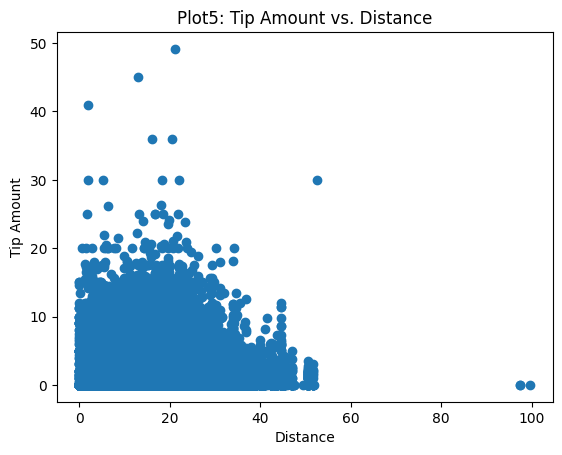

In [58]:
re_outliers = data_for_visual_q5()
plot_question5(re_outliers)

### Visualization 6: Create another scatter plot that compares tip amount versus precipitation amount for Yellow Taxi rides. 

In [59]:
def data_for_visual_q6():
    #Select data from SQLlite database
    tip_amount = c1.execute('SELECT tip_amount, month, day, year FROM taxi_data3').fetchall()
    tip_table = pd.DataFrame(tip_amount, columns = ['tip_amount', 'month', 'day', 'year'])
    prec_daily = c2.execute('SELECT daily_precipitation, month, day, year FROM daily_data4').fetchall()
    daily_prec = pd.DataFrame(prec_daily, columns = ['daily_precipitation', 'month', 'day', 'year']) 
    #join together
    Qu_tip_vs_prec= """
    SELECT * FROM tip_table t
    JOIN daily_prec d ON t.month = d.month AND t.year = d.year AND t.day = d.day
    GROUP BY t.month, t.year, t.day
    """
    tip_vs_prec = sqldf(Qu_tip_vs_prec)
    #remove coutliers
    rem_outliers = tip_vs_prec[(tip_vs_prec["daily_precipitation"]<8) & (tip_vs_prec["tip_amount"] < 20)]
    return rem_outliers

In [60]:
def plot_question6(dataframe):
    #make scatter plot
    plt.title("Plot6: Tip Amount vs. Daily Precipitation")
    plt.xlabel("Daily Precipitation")
    plt.ylabel("Tip Amount")
    plt.scatter(dataframe["daily_precipitation"], dataframe["tip_amount"])

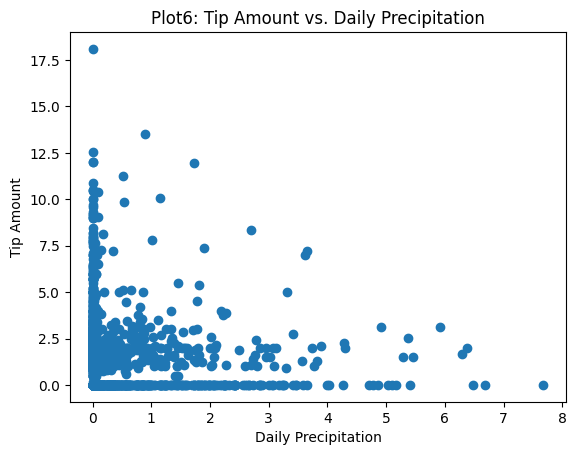

In [61]:
tip_vs_prec = data_for_visual_q6()
plot_question6(tip_vs_prec)

In [63]:
tip_amount = c1.execute('SELECT tip_amount, month, day, year FROM taxi_data3').fetchall()
tip_table = pd.DataFrame(tip_amount, columns = ['tip_amount', 'month', 'day', 'year'])
prec_daily = c2.execute('SELECT daily_precipitation, month, day, year FROM daily_data4').fetchall()
daily_prec = pd.DataFrame(prec_daily, columns = ['daily_precipitation', 'month', 'day', 'year']) 
Qu_tip_vs_prec= """
SELECT * FROM tip_table t
    JOIN daily_prec d ON t.month = d.month AND t.year = d.year AND t.day = d.day
    GROUP BY t.month, t.year, t.day
    """
tip_vs_prec = sqldf(Qu_tip_vs_prec)
outfile8 = "visual_tip_prec.sql"
write_query_to_file(Qu_tip_vs_prec, outfile8)   